<a href="https://colab.research.google.com/github/DesiPilla/demographics-voterid-turnout/blob/master/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install geopandas
import geopandas as gp

from statsmodels.stats.weightstats import ztest
from scipy.stats import f_oneway

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Analysis

In [0]:
# Load full datasets (only one nan row)
data = gp.read_file('/content/drive/My Drive/MLPP Project/Data/data.shp').dropna()
data_mainland = gp.read_file('/content/drive/My Drive/MLPP Project/Data/data_mainland.shp').dropna()
data_no_ak = gp.read_file('/content/drive/My Drive/MLPP Project/Data/data_no_ak.shp').dropna()

In [0]:
# Load demographic datasets
demgeo = gp.read_file('/content/drive/My Drive/MLPP Project/Data/demgeo.shp')
demgeo_mainland = gp.read_file('/content/drive/My Drive/MLPP Project/Data/demgeo_mainland.shp')

# Load voter ID datasets
votgeo = gp.read_file('/content/drive/My Drive/MLPP Project/Data/votgeo.shp')
votgeo_mainland = gp.read_file('/content/drive/My Drive/MLPP Project/Data/votgeo_mainland.shp')

# Load turnout datasets
turngeo = gp.read_file('/content/drive/My Drive/MLPP Project/Data/turngeo.shp')
turngeo_mainland = gp.read_file('/content/drive/My Drive/MLPP Project/Data/turngeo_mainland.shp')

## Classify "disadvantaged" counties

We will weight certain features to classify counties as either “disadvantaged” or “non-disadvantaged”.

The four features being used to create this "disadvantage index" are the following:
 * `1 - MedieanHous`: the smaller the median househole income, the more disadvantaged the county is.
 * `1 - CollegeDeg`: the smaller the percentage of residents with a college degree, the more disadvantaged the county is.
 * `MedianAge`: the larger the median age, the more disadvantaged the county is.
 * `not_white`: the larger the minority population, the more disadvantaged the county is.

In [38]:
cols = ['MedianHous', 'CollegeDeg', 'MedianAge', 'not_white']

# Get county fips and geometry for future use
county_fip = data_no_ak.county_fip
geometry = data_no_ak.geometry

# Get features and standardize them
feat = data_no_ak[cols]
feat_st = (feat - feat.mean()) / feat.std()

# Orient the features so lower values correspond to more disadvantage
feat_st['MedianHous'] = 1 - feat_st['MedianHous']
feat_st['CollegeDeg'] = 1 - feat_st['CollegeDeg']

# sum across the features and weight equally
data_no_ak['disadvantage_index'] = feat_st.sum(axis=1) / 4
data_no_ak['disadvantage_index'] -= data_no_ak.disadvantage_index.min()
data_no_ak['disadvantage_index'] /= data_no_ak.disadvantage_index.max()
data_no_ak['disadvantaged'] = data_no_ak['disadvantage_index'] > data_no_ak['disadvantage_index'].quantile(0.85)
data_no_ak[['county_fip'] + cols + ['disadvantage_index', 'disadvantaged']].head()

,county_fip,MedianHous,CollegeDeg,MedianAge,not_white,disadvantage_index,disadvantaged
0,31039,50013.0,0.383511,43.6,0.039987,0.578743,False
1,31109,51830.0,0.517659,32.9,0.126604,0.416972,False
2,31129,40488.0,0.337133,49.2,0.020269,0.695995,False
3,31101,41781.0,0.360804,49.1,0.035232,0.681118,False
4,31137,50404.0,0.380159,42.0,0.029188,0.559238,False


,county_fip,MedianHous,CollegeDeg,MedianAge,not_white,disadvantage_index,disadvantaged
0,31039,50013.0,0.383511,43.6,0.039987,0.578743,False
1,31109,51830.0,0.517659,32.9,0.126604,0.416972,False
2,31129,40488.0,0.337133,49.2,0.020269,0.695995,False
3,31101,41781.0,0.360804,49.1,0.035232,0.681118,False
4,31137,50404.0,0.380159,42.0,0.029188,0.559238,False


,county_fip,MedianHous,CollegeDeg,MedianAge,not_white,disadvantage_index,disadvantaged
0,31039,50013.0,0.383511,43.6,0.039987,0.578743,False
1,31109,51830.0,0.517659,32.9,0.126604,0.416972,False
2,31129,40488.0,0.337133,49.2,0.020269,0.695995,False
3,31101,41781.0,0.360804,49.1,0.035232,0.681118,False
4,31137,50404.0,0.380159,42.0,0.029188,0.559238,False


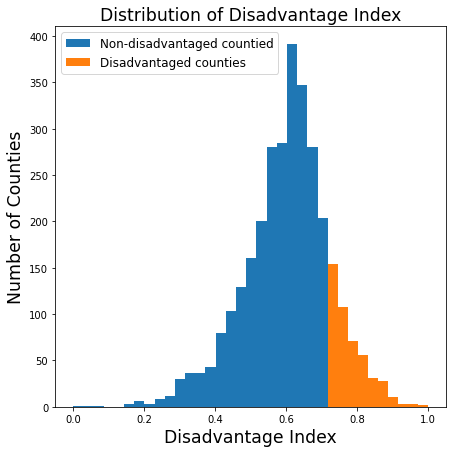

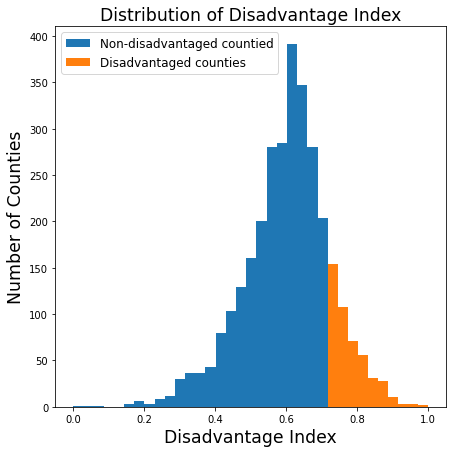

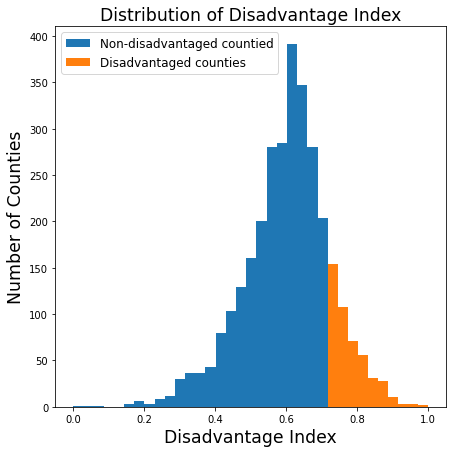

In [39]:
fig, ax = plt.subplots(figsize=(7, 7));
ax.hist(data_no_ak[~data_no_ak.disadvantaged].disadvantage_index, bins=25, label='Non-disadvantaged countied')
ax.hist(data_no_ak[data_no_ak.disadvantaged].disadvantage_index, bins=10, label='Disadvantaged counties')
ax.set_title('Distribution of Disadvantage Index', fontsize='xx-large')
ax.set_ylabel('Number of Counties', fontsize='xx-large')
ax.set_xlabel('Disadvantage Index', fontsize='xx-large')
ax.legend(fontsize='large')

fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/disadvantage_index_hist.png', clobber=True)
fig.show();

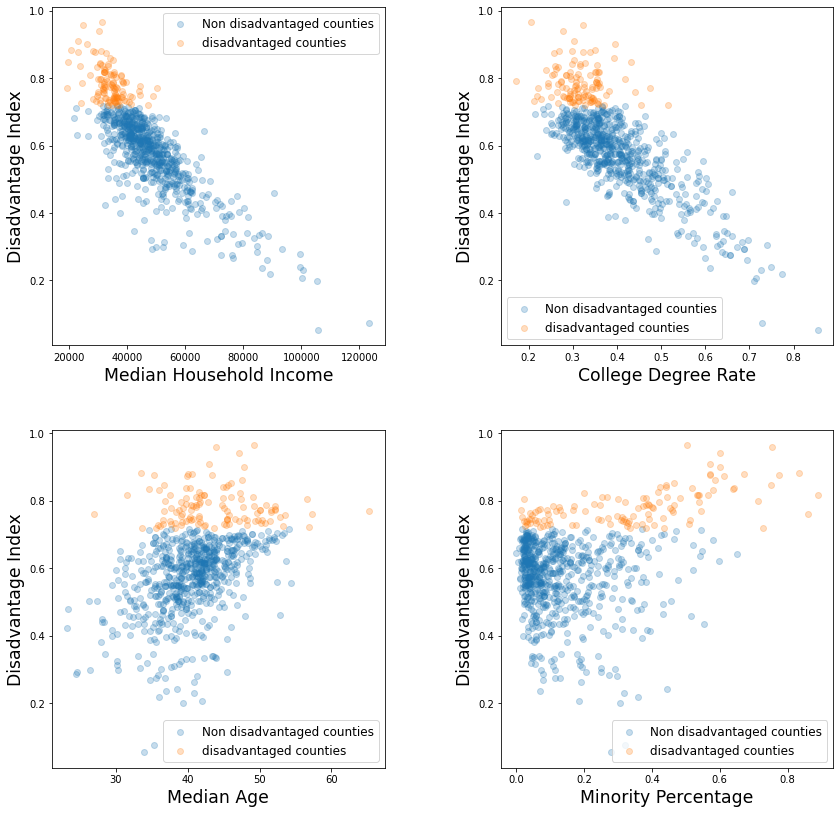

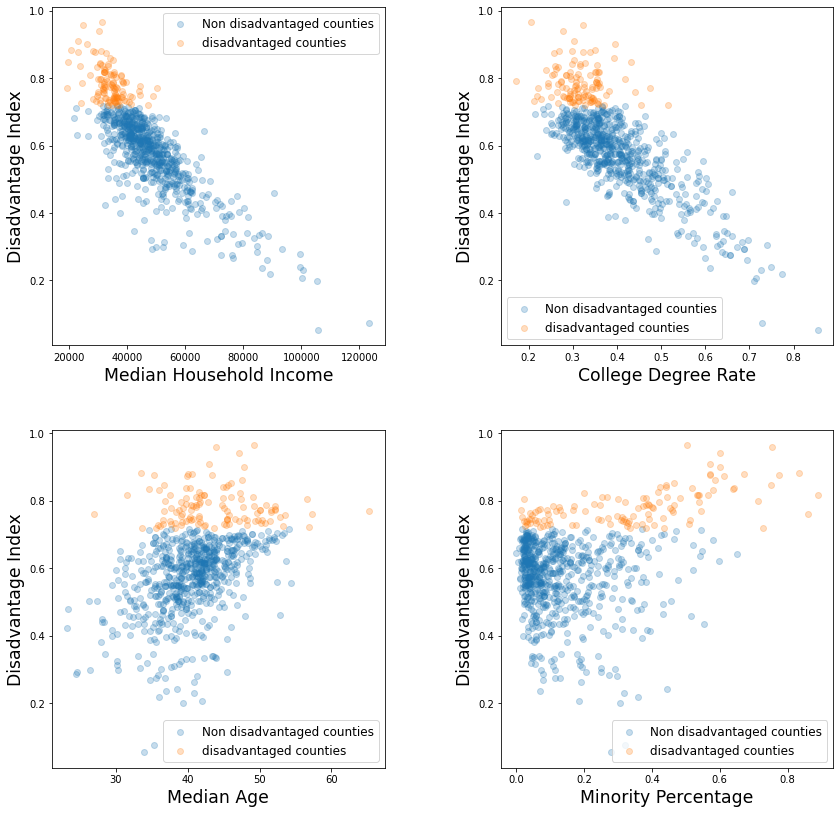

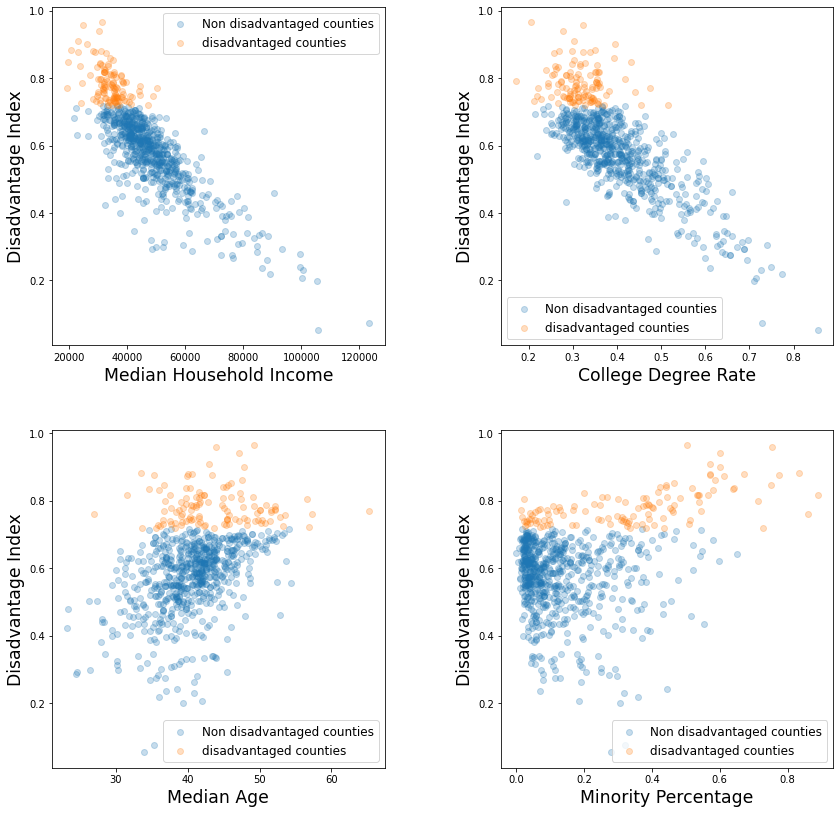

In [40]:
feat_names = ['Median Household Income', 'College Degree Rate', 'Median Age', 'Minority Percentage']
feat_labels = ['Median\nHousehold\nIncome', 'College\nDegree\nRate', 'Median Age', 'Minority\nPercentage']

r, c = 2, 2
fig, ax = plt.subplots(r, c, figsize=(7*c, 7*r))
for i in range(np.prod(ax.shape)):

    # Get index of counties in the bottom 25th percentile
    idx = data_no_ak.disadvantaged
    step = 4
    alpha = 0.25

    # Plot the counties, colored by their percentile
    ax[i // c][i % c].scatter(feat.values[~idx, i][::step], data_no_ak['disadvantage_index'][~idx][::step], alpha=alpha, label='Non disadvantaged counties')
    ax[i // c][i % c].scatter(feat.values[idx, i][::step], data_no_ak['disadvantage_index'][idx][::step], alpha=alpha, label='disadvantaged counties')

    ax[i // c][i % c].set_ylabel('Disadvantage Index', fontsize='xx-large')
    ax[i // c][i % c].set_xlabel(feat_names[i], fontsize='xx-large')
    ax[i // c][i % c].legend(fontsize='large')

fig.subplots_adjust(hspace=0.25, wspace=0.35)
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/disadvantage_index_correlations.png', clobber=True)
fig.show();

## ANOVA and z-tests

In [0]:
def make_bins(xcol, ycol, n_bins=4):
    bins, means, stds, labels = [], [], [], []

    for i in range(n_bins):
        # Get values in the i-th bin
        bot = i / n_bins
        top = (i + 1) / n_bins
        labels.append('{0:.0%} - {1:.0%}'.format(bot, top))

        idx = (data_no_ak[xcol] > data_no_ak[xcol].quantile(bot)) & (data_no_ak[xcol] < data_no_ak[xcol].quantile(top))

        # Get bin data
        bins.append(data_no_ak[idx][ycol].values)
        means.append(np.mean(bins[i]))
        stds.append(np.std(bins[i]))

    return np.array(bins), means, stds, labels

def plot_split(xcol, ycol='turnout', n_bins=4, title=None):
    
    bins, means, stds, labels = make_bins(xcol, ycol, n_bins)

    # Plot the performance
    fig, ax = plt.subplots(figsize=(2*n_bins, 5))

    # Make the plot
    ax.bar(np.arange(len(means)), means, edgecolor='white')
    ax.errorbar(np.arange(len(means)), means, yerr=stds, fmt=',k', capsize=10)
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(labels, fontsize='large')
    ax.set_xlabel('Percentile Bins', fontsize='x-large')

    if ycol == 'turnout':
        ax.set_ylabel('Turnout Rate', fontsize='x-large')
        ax.set_ylim(0, 1)
        ax.set_title('Turnout Rate by {0}'.format(title), fontsize='xx-large')
    elif ycol =='VoterIDLaw':
        ax.set_ylabel('Average Voter ID Law', fontsize='x-large')
        ax.set_title('Voter ID Law Strictness by {0}'.format(title), fontsize='xx-large')

    return fig

def print_ztest(sample1, sample2, target='turnout rate', alpha=0.05):
    dis_std = np.std(dis)
    non_dis_std = np.std(non_dis)

    z_statistic, pval = ztest(sample1,sample2)

    print('Null hypothesis: The two samlpes have the \033[1msame mean', target)
    print("\n\033[0mdisadvantaged mean value: {0:.4f}".format(np.mean(sample1)))
    print("non-disadvantaged mean value: {0:.4f}".format(np.mean(sample2)))

    print("\ndisadvantaged std value: {0:.4f}".format(np.std(sample1)))
    print("non-disadvantaged std value: {0:.4f}".format(np.std(sample2)))

    print("\np-value for {0:.4f} significance: {1:.2e}\033[1m".format(alpha, pval))
    if pval < alpha:
        print("we reject null hypothesis")
    else:
        print("we accept null hypothesis")
    print('\033[0m\n\n')



def print_anova(xcol, ycol='turnout', n_bins=4, target='turnout rate', alpha=0.05):
    bins, means, stds, labels = make_bins('MedianHous', 'turnout')
    F, p = f_oneway(*bins)

    print('Null hypothesis: The samlpes have the \033[1msame mean', target, '\033[0m')
    print("\np-value for {0:.4f} significance: {1:.2e}\033[1m".format(alpha, pval))
    if p < alpha:
        print("we reject null hypothesis")
    else:
        print("we accept null hypothesis")
    print('\033[0m')

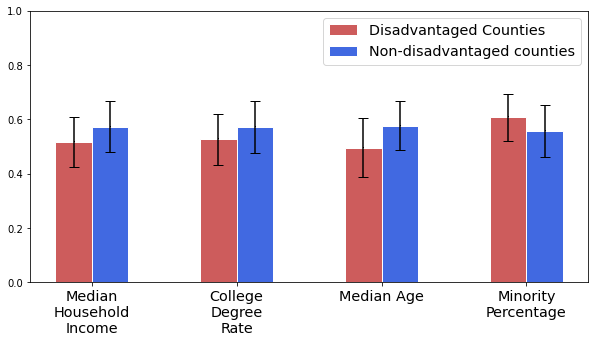

In [53]:
dis_means, non_dis_means = [], []
dis_stds, non_dis_stds = [], []
pvals = []

for c in cols:
    idx = data_no_ak[c] < data_no_ak[c].quantile(0.15)

    # Split the data into disadvantaged and non-disadvantaged
    dis = data_no_ak[idx].turnout.values
    non_dis = data_no_ak[~idx].turnout.values

    # Find the mean of each group
    dis_mean = np.mean(dis)
    dis_means.append(dis_mean)
    non_dis_mean = np.mean(non_dis)
    non_dis_means.append(non_dis_mean)

    # Fint the standard deviation of each group
    dis_std = np.std(dis)
    dis_stds.append(dis_std)
    non_dis_std = np.std(non_dis)
    non_dis_stds.append(non_dis_std)

    # Conduct a z-test on the two groups
    z_statistic, pval = ztest(dis,non_dis)
    pvals.append(pval)

# Set position of bar on X axis
barWidth = 0.25
x1 = np.arange(len(dis_means))
x2 = [x + barWidth for x in x1]

# Plot the performance
fig, ax = plt.subplots(figsize=(10, 5))

# Make the plot
ax.bar(x1, dis_means, color='indianred', width=barWidth, edgecolor='white', label='Disadvantaged Counties')
ax.errorbar(x1, dis_means, yerr=dis_stds, fmt=',k', capsize=5)
ax.bar(x2, non_dis_means, color='royalblue', width=barWidth, edgecolor='white', label='Non-disadvantaged counties')
ax.errorbar(x2, non_dis_means, yerr=non_dis_stds, fmt=',k', capsize=5)
ax.set_xticks((x1 + x2)/2)
ax.set_xticklabels(feat_labels, fontsize='x-large', rotation=0)
ax.set_ylim(0, 1)
ax.set_title('', fontsize='x-large')
ax.legend(fontsize='x-large')

fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/disadvantaged_conditional_turnouts.png', clobber=True)
fig.show();

In [54]:
print_ztest(dis, non_dis)

Null hypothesis: The two samlpes have the same mean turnout rate

disadvantaged mean value: 0.6071
non-disadvantaged mean value: 0.5573

disadvantaged std value: 0.0850
non-disadvantaged std value: 0.0969

p-value for 0.0500 significance: 2.07e-25
we reject null hypothesis





In [55]:
print_anova('MedianHous', 'turnout', n_bins=4, target='Median Household Income')

Null hypothesis: The samlpes have the same mean Median Household Income 

p-value for 0.0500 significance: 2.07e-25
we reject null hypothesis



## Conditional turnout rates

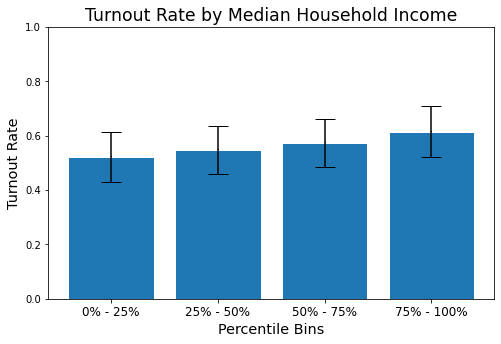

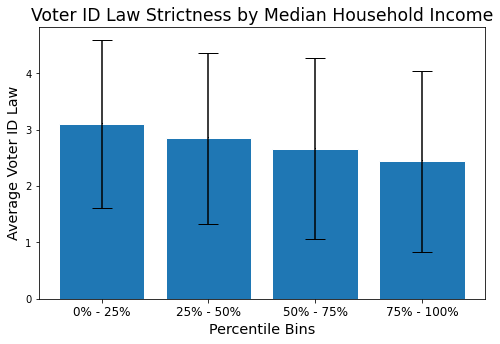

In [46]:
fig = plot_split('MedianHous', 'turnout', 4, 'Median Household Income');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/medianhous_conditional_turnouts.png', clobber=True)

fig = plot_split('MedianHous', 'VoterIDLaw', 4, 'Median Household Income');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/medianhous_conditional_idlaw.png', clobber=True)

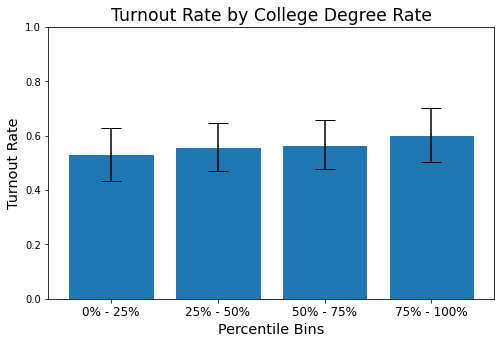

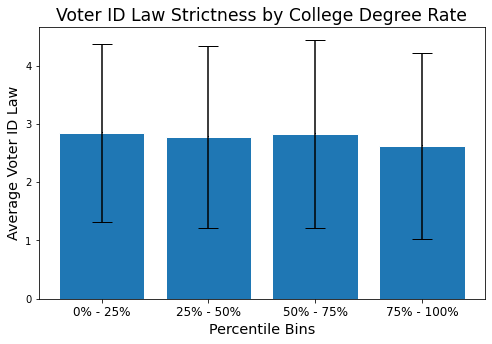

In [292]:
fig = plot_split('CollegeDeg', 'turnout', 4, 'College Degree Rate');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/collegedeg_conditional_turnouts.png', clobber=True)

fig = plot_split('CollegeDeg', 'VoterIDLaw', 4, 'College Degree Rate');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/collegedeg_conditional_idlaw.png', clobber=True)

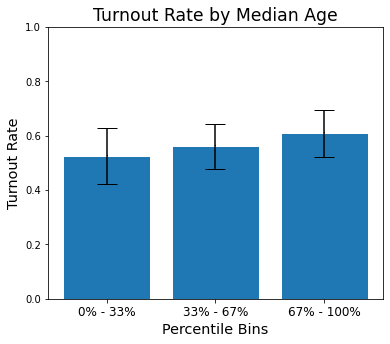

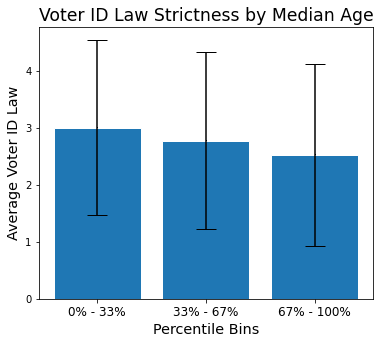

In [293]:
fig = plot_split('MedianAge', 'turnout', 3, 'Median Age');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/medianage_conditional_turnouts.png', clobber=True)

fig = plot_split('MedianAge', 'VoterIDLaw', 3, 'Median Age');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/medianage_conditional_idlaw.png', clobber=True)

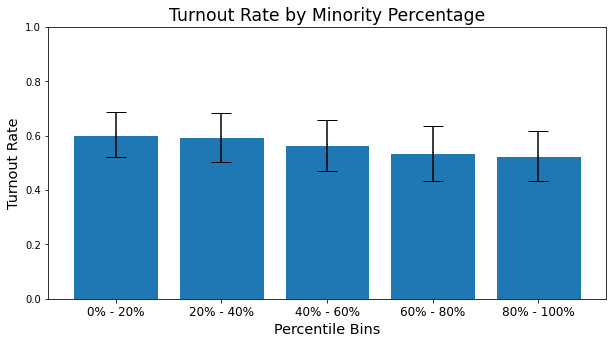

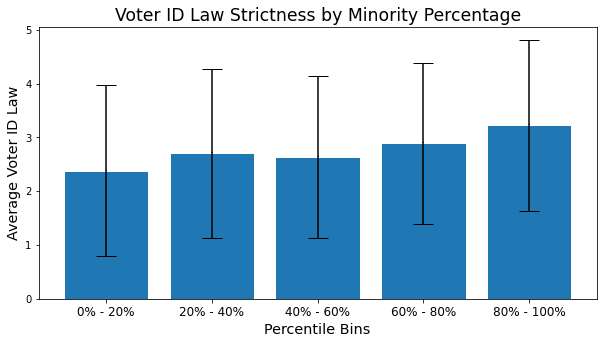

In [294]:
fig = plot_split('not_white', 'turnout', 5, 'Minority Percentage');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/minority_conditional_turnouts.png', clobber=True)

fig = plot_split('not_white', 'VoterIDLaw', 5, 'Minority Percentage');
fig.savefig('/content/drive/My Drive/MLPP Project/Pictures/minority_conditional_idlaw.png', clobber=True)

## Clustering


## Random Forest

# Stochastic Gradient Descent